In [3]:
import numpy as np
from matplotlib import pyplot as plt
import numpy.linalg as nl
import os
import h5py
import fipy as fp
from fipy import Gmsh2D
import itertools
import cmath
import pandas as pd

In [4]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['font.size']=20
plt.rcParams["text.usetex"]=True

### Fourier transform of dynamical model

Non-dimensionalized equations in real space:

$$
\partial_{t} c = M \nabla^2 \Big( c^3 + \beta c + \gamma m - \kappa \nabla^2 c \Big) \\
\partial_{t} m = \nabla^2 \Big( m + \gamma w c \Big) + K c - m \\
$$

Under the strong segregation limit, the non-linear $c^3$ term is not very important for the dynamics. In this limit, the Fourier Transform of these linear equations looks like:

$$
\partial_t \begin{bmatrix} c_q \\ m_q \end{bmatrix} = 
\begin{bmatrix} -M \beta q^2 - M \kappa q^4 & -M \gamma q^2 \\ -\gamma w q^2 + K & -1-q^2 \end{bmatrix} 
\begin{bmatrix} c_q \\ m_q \end{bmatrix}
$$

**Approximation 1:**

When surface tension effects are not important ($\kappa = 0$) and the species m undergoes only pure diffusion ($w=0$), the trace and determinant are given by:
$$
Tr(J) = - (M \beta + 1) q^2 - 1 \\
Det(J) = M \beta q^2 \Big( q^2 + \frac{\gamma K}{\beta} + 1 \Big)
$$

Tasks:
1. For a given set of parameters, plot the trace and the determinant of the above matrix for different values of q

### Analysis of Approximation 1

In [5]:
class approximation_1:
    """
    Class that defines the dynamical model for the C-M system as described by approximation 1
    """
    
    def __init__(self, params):
        """
        Parameters of the model are M, beta, gamma, K
        """
        self.M = params['M'] # Ratio of diffusivities of M to C
        self.beta = params['beta'] # Nature of C-C interactions. Attraction if negative
        self.gamma = params['gamma'] # Nature of C-M interactions. Attractive if negative
        self.K = params['K'] # Ratio of production to degradation rate constants of M
        
    def _get_trace(self, q):
        """
        Function that returns the trace of the Jacobian matrix of the linearized model
        """
        return -(self.M*self.beta + 1.0)*q**2 - 1.0
    
    def _get_det(self, q):
        """
        Function that returns the determinant of the Jacobian matrix of the linearized model
        """
        return self.M*self.beta*q**2*(q**2 + self.gamma*self.K/self.beta + 1)
    
    def _get_phase_plot_data(self, q_range):
        """
        Function that takes in a range of values of the wave number q_range, and computes the determinant and trace
        """
        trace_range = self._get_trace(q_range)
        det_range = self._get_det(q_range)
        return trace_range, det_range
    
    def plot_phase_plot(self, ax, q_range):
        """
        Function to generate phase plots that help us visualize the different dynamical behaviors when perturbed about a steady state
        """
        trace, det = self._get_phase_plot_data(q_range)
        
        # plot the regions of different dynamical behaviors
        x_max = np.max(np.abs(trace))
        y_max = np.max(np.abs(det))
        x_range = np.linspace(-1.2*x_max, 1.2*x_max, 50)
        y_oscillatory_region = x_range**2/4.0
        ax.plot(x_range, y_oscillatory_region, '-k', linewidth=1)
        
        # Plot the phase plot for this model parameters
        ax.plot(trace, det, '-r', linewidth=2)
        ax.set_xlim([-1.2*x_max, 1.2*x_max])
        ax.set_ylim([-1.2*y_max, 1.2*y_max])
        
        ax.set_xlabel('tr(J)')
        ax.set_ylabel('det(J)')
        ax.axhline(y=0.0, color='k', linestyle='-')
        ax.axvline(x=0.0, color='k', linestyle='-')

### Generate plots for different model parameters

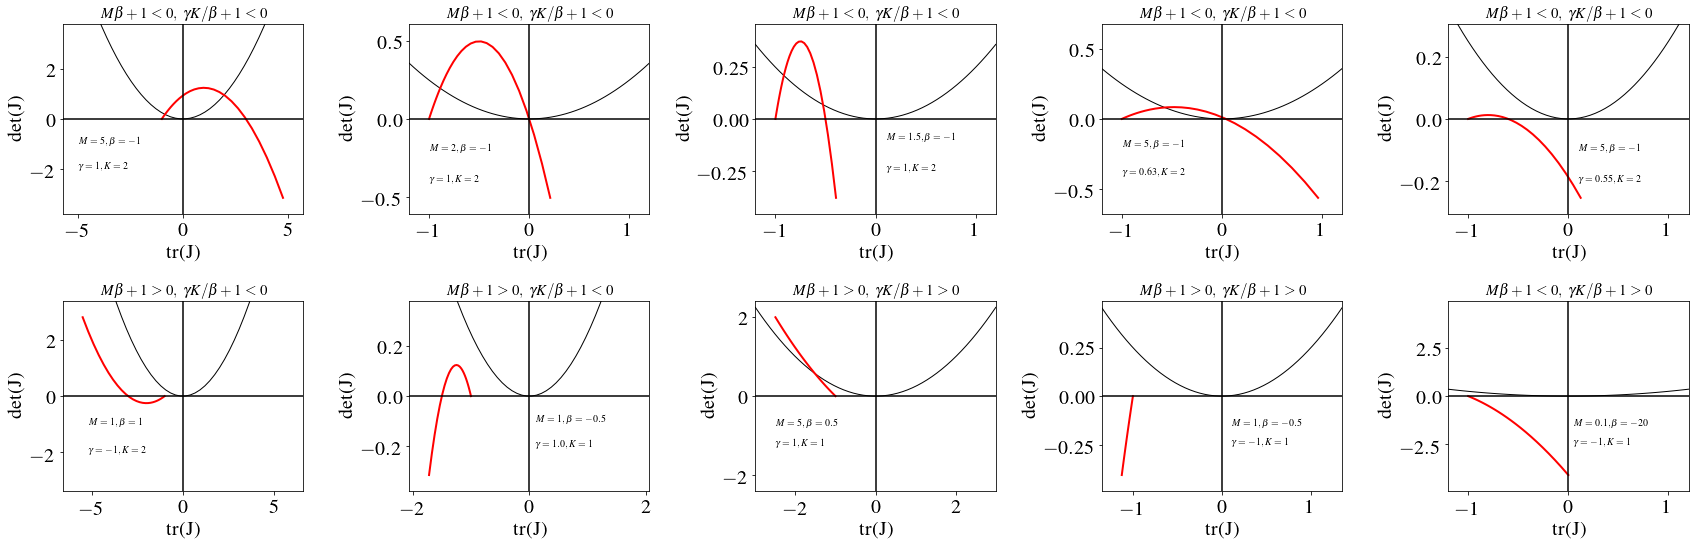

In [140]:
fig, axs = plt.subplots(2, 5, figsize=(24,8), constrained_layout = True)

# Case 1: M*beta + 1 < 0, and gamma*K/beta + 1 < 0

params = {'M': 5,
          'beta': -1,
          'gamma': 1,
          'K': 2
         }

q_range = np.linspace(0,1.2,30)
analysis_obj = approximation_1(params)
analysis_obj.plot_phase_plot(axs[0,0], q_range)
axs[0,0].set_title(r'$M \beta + 1 < 0, ~ \gamma K / \beta + 1 < 0$', fontsize=15)
axs[0,0].text(-5.0, -1.0, r'$M = 5, \beta = -1$', fontsize=10)
axs[0,0].text(-5.0, -2.0, r'$\gamma = 1, K = 2$', fontsize=10)

params = {'M': 2.0,
          'beta': -1,
          'gamma': 1.0,
          'K': 2
         }

q_range = np.linspace(0,1.1,30)
analysis_obj = approximation_1(params)
analysis_obj.plot_phase_plot(axs[0,1], q_range)
axs[0,1].set_title(r'$M \beta + 1 < 0, ~ \gamma K / \beta + 1 < 0$', fontsize=15)
axs[0,1].text(-1.0, -0.2, r'$M = 2, \beta = -1$', fontsize=10)
axs[0,1].text(-1.0, -0.4, r'$\gamma = 1, K = 2$', fontsize=10)

params = {'M': 1.5,
          'beta': -1,
          'gamma': 1.0,
          'K': 2
         }

q_range = np.linspace(0,1.1,30)
analysis_obj = approximation_1(params)
analysis_obj.plot_phase_plot(axs[0,2], q_range)
axs[0,2].set_title(r'$M \beta + 1 < 0, ~ \gamma K / \beta + 1 < 0$', fontsize=15)
axs[0,2].text(0.1, -0.1, r'$M = 1.5, \beta = -1$', fontsize=10)
axs[0,2].text(0.1, -0.25, r'$\gamma = 1, K = 2$', fontsize=10)

params = {'M': 5.0,
          'beta': -1,
          'gamma': 0.63,
          'K': 2
         }

q_range = np.linspace(0,0.7,30)
analysis_obj = approximation_1(params)
analysis_obj.plot_phase_plot(axs[0,3], q_range)
axs[0,3].set_title(r'$M \beta + 1 < 0, ~ \gamma K / \beta + 1 < 0$', fontsize=15)
axs[0,3].text(-1.0, -0.2, r'$M = 5, \beta = -1$', fontsize=10)
axs[0,3].text(-1.0, -0.4, r'$\gamma = 0.63, K = 2$', fontsize=10)

params = {'M': 5.0,
          'beta': -1,
          'gamma': 0.55,
          'K': 2
         }

q_range = np.linspace(0,0.53,30)
analysis_obj = approximation_1(params)
analysis_obj.plot_phase_plot(axs[0,4], q_range)
axs[0,4].set_title(r'$M \beta + 1 < 0, ~ \gamma K / \beta + 1 < 0$', fontsize=15)
axs[0,4].text(0.1, -0.1, r'$M = 5, \beta = -1$', fontsize=10)
axs[0,4].text(0.1, -0.2, r'$\gamma = 0.55, K = 2$', fontsize=10)

# Case 2: M*beta + 1 > 0, and gamma*K/beta + 1 < 0

# Sub case: beta > 0

params = {'M': 1.0,
          'beta': 1,
          'gamma': -1.0,
          'K': 2
         }

q_range = np.linspace(0,1.5,30)
analysis_obj = approximation_1(params)
analysis_obj.plot_phase_plot(axs[1,0], q_range)
axs[1,0].set_title(r'$M \beta + 1 > 0, ~ \gamma K / \beta + 1 < 0$', fontsize=15)
axs[1,0].text(-5.2, -1.0, r'$M = 1, \beta = 1$', fontsize=10)
axs[1,0].text(-5.2, -2.0, r'$\gamma = -1, K = 2$', fontsize=10)

# sub case: beta < 0

params = {'M': 1.0,
          'beta': -0.5,
          'gamma': 1.0,
          'K': 1
         }

q_range = np.linspace(0,1.2,30)
analysis_obj = approximation_1(params)
analysis_obj.plot_phase_plot(axs[1,1], q_range)
axs[1,1].set_title(r'$M \beta + 1 > 0, ~ \gamma K / \beta + 1 < 0$', fontsize=15)
axs[1,1].text(0.1, -0.1, r'$M = 1, \beta = -0.5$', fontsize=10)
axs[1,1].text(0.1, -0.2, r'$\gamma = 1.0, K = 1$', fontsize=10)

# Case 3: M*beta + 1 > 0, and gamma*K/beta + 1 > 0

# Sub case: beta > 0

params = {'M': 1.0,
          'beta': 0.5,
          'gamma': 1.0,
          'K': 1
         }

q_range = np.linspace(0,1.0,30)
analysis_obj = approximation_1(params)
analysis_obj.plot_phase_plot(axs[1,2], q_range)
axs[1,2].set_title(r'$M \beta + 1 > 0, ~ \gamma K / \beta + 1 > 0$', fontsize=15)
axs[1,2].text(-2.5, -0.75, r'$M = 5, \beta = 0.5$', fontsize=10)
axs[1,2].text(-2.5, -1.25, r'$\gamma = 1, K = 1$', fontsize=10)

# Sub case: beta < 0

params = {'M': 1.0,
          'beta': -0.5,
          'gamma': -1.0,
          'K': 1
         }

q_range = np.linspace(0,0.5,30)
analysis_obj = approximation_1(params)
analysis_obj.plot_phase_plot(axs[1,3], q_range)
axs[1,3].set_title(r'$M \beta + 1 > 0, ~ \gamma K / \beta + 1 > 0$', fontsize=15)
axs[1,3].text(0.1, -0.15, r'$M = 1, \beta = -0.5$', fontsize=10)
axs[1,3].text(0.1, -0.25, r'$\gamma = -1, K = 1$', fontsize=10)


# Case 4: M*beta + 1 < 0, and gamma*K/beta + 1 > 0

params = {'M': 0.1,
          'beta': -20.0,
          'gamma': -1.0,
          'K': 1
         }

q_range = np.linspace(0,1.0,30)
analysis_obj = approximation_1(params)
analysis_obj.plot_phase_plot(axs[1,4], q_range)
axs[1,4].set_title(r'$M \beta + 1 < 0, ~ \gamma K / \beta + 1 > 0$', fontsize=15)
axs[1,4].text(0.05, -1.5, r'$M = 0.1, \beta = -20$', fontsize=10)
axs[1,4].text(0.05, -2.5, r'$\gamma = -1, K = 1$', fontsize=10)


fig.tight_layout()
plt.savefig('20220526_Stability_Plot_Approximation_1.svg', format='svg', dpi=600)
plt.savefig('20220526_Stability_Plot_Approximation_1.png', format='png', dpi=600)

### Analysis of approximation 2

Non-dimensionalized equations in real space:

$$
\partial_{t} c = M \nabla^2 \Big( c^3 + \beta c + \gamma m - \kappa \nabla^2 c \Big) \\
\partial_{t} m = \nabla^2 \Big( m + \gamma w c \Big) + K c - m \\
$$

Under the strong segregation limit, the non-linear $c^3$ term is not very important for the dynamics. In this limit, the Fourier Transform of these linear equations looks like:

$$
\partial_t \begin{bmatrix} c_q \\ m_q \end{bmatrix} = 
\begin{bmatrix} -M \beta q^2 - M \kappa q^4 & -M \gamma q^2 \\ -\gamma w q^2 + K & -1-q^2 \end{bmatrix} 
\begin{bmatrix} c_q \\ m_q \end{bmatrix}
$$

**Approximation 2:**

When surface tension effects are important and the species m undergoes only pure diffusion ($w=0$), the trace and determinant are given by:
$$
Tr(J) = - M \kappa q^4 - (M \beta + 1) q^2 - 1 \\
Det(J) = M \kappa q^6 + (M \kappa + M \beta) q^4 + M \beta q^2 \Big( \frac{\gamma K}{\beta} + 1 \Big)
$$

In [26]:
class approximation_2:
    """
    Class that defines the dynamical model for the C-M system as described by approximation 1
    """
    
    def __init__(self, params):
        """
        Parameters of the model are M, beta, gamma, K
        """
        self.M = params['M'] # Ratio of diffusivities of M to C
        self.beta = params['beta'] # Nature of C-C interactions. Attraction if negative
        self.gamma = params['gamma'] # Nature of C-M interactions. Attractive if negative
        self.K = params['K'] # Ratio of production to degradation rate constants of M
        self.kappa = params['kappa'] # Ratio of surface tension to reaction-diffusion length scale
        
    def _get_eigenvalues(self, q):
        """
        Fuction that returns a 2x1 vector containing the eigenvalues of the Jacobian matrix
        """
        J = np.array([[-self.M*self.beta*q**2 - self.M*self.kappa*q**4, -self.M*self.gamma*q**2],[self.K, -1-q**2]], 
                     dtype=float)
        eigenvals, eigenvecs = nl.eig(J)
        return eigenvals
    
    def _get_trace(self, q):
        """
        Function that returns the trace of the Jacobian matrix of the linearized model
        """
        return -self.M*self.kappa*q**4 -(self.M*self.beta + 1.0)*q**2 - 1.0
    
    def _get_det(self, q):
        """
        Function that returns the determinant of the Jacobian matrix of the linearized model
        """
        return self.M*self.kappa*q**6 + (self.M*self.kappa + self.M*self.beta)*q**4 + self.M*self.beta*q**2*(self.gamma*self.K/self.beta + 1)
    
    def _get_phase_plot_data(self, q_range):
        """
        Function that takes in a range of values of the wave number q_range, and computes the determinant and trace
        """
        trace_range = self._get_trace(q_range)
        det_range = self._get_det(q_range)
        return trace_range, det_range
    
    def plot_phase_plot(self, ax, q_range):
        """
        Function to generate phase plots that help us visualize the different dynamical behaviors when perturbed about a steady state
        """
        trace, det = self._get_phase_plot_data(q_range)
        
        # plot the regions of different dynamical behaviors
        x_max = np.max(np.abs(trace))
        y_max = np.max(np.abs(det))
        x_range = np.linspace(-1.2*x_max, 1.2*x_max, 50)
        y_oscillatory_region = x_range**2/4.0
        ax.plot(x_range, y_oscillatory_region, '-k', linewidth=1)
        
        # Plot the phase plot for this model parameters
        ax.plot(trace, det, '-r', linewidth=2)
        ax.set_xlim([-1.2*x_max, 1.2*x_max])
        ax.set_ylim([-1.2*y_max, 1.2*y_max])
        
        ax.set_xlabel('tr(J)')
        ax.set_ylabel('det(J)')
        ax.axhline(y=0.0, color='k', linestyle='-')
        ax.axvline(x=0.0, color='k', linestyle='-')

/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/figure.py:2117: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "
/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (53) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/times/utmr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (48) of font 

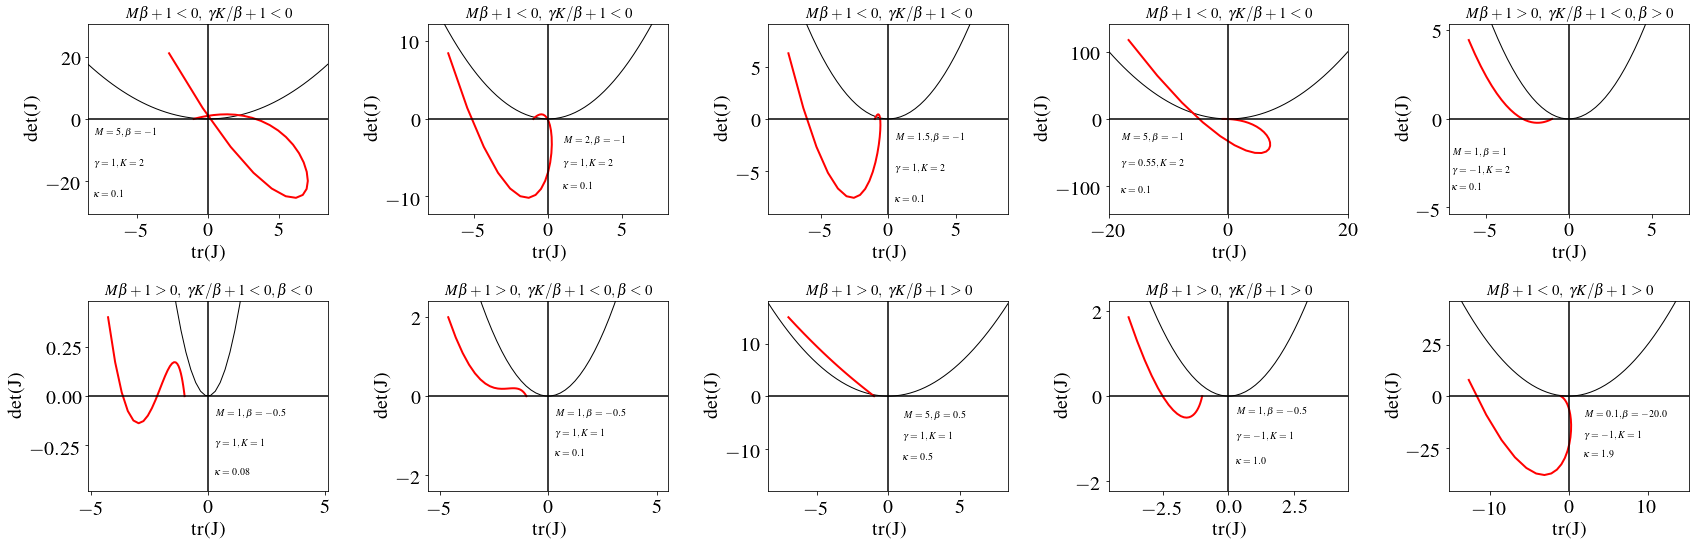

In [6]:
fig, axs = plt.subplots(2, 5, figsize=(24,8), constrained_layout = True)

# Case 1: M*beta + 1 < 0, and gamma*K/beta + 1 < 0

params = {'M': 5,
          'beta': -1,
          'gamma': 1,
          'K': 2,
          'kappa': 0.1
         }

q_range = np.linspace(0,2.9,30)
analysis_obj = approximation_2(params)
analysis_obj.plot_phase_plot(axs[0,0], q_range)
axs[0,0].set_title(r'$M \beta + 1 < 0, ~ \gamma K / \beta + 1 < 0$', fontsize=15)
axs[0,0].text(-8.0, -5.0, r'$M = 5, \beta = -1$', fontsize=10)
axs[0,0].text(-8.0, -15.0, r'$\gamma = 1, K = 2$', fontsize=10)
axs[0,0].text(-8.0, -25.0, r'$\kappa = 0.1$', fontsize=10)


params = {'M': 2,
          'beta': -1,
          'gamma': 1,
          'K': 2,
          'kappa': 0.1
         }

q_range = np.linspace(0,2.9,30)
analysis_obj = approximation_2(params)
analysis_obj.plot_phase_plot(axs[0,1], q_range)
axs[0,1].set_title(r'$M \beta + 1 < 0, ~ \gamma K / \beta + 1 < 0$', fontsize=15)
axs[0,1].text(1.0, -3.0, r'$M = 2, \beta = -1$', fontsize=10)
axs[0,1].text(1.0, -6.0, r'$\gamma = 1, K = 2$', fontsize=10)
axs[0,1].text(1.0, -9.0, r'$\kappa = 0.1$', fontsize=10)

params = {'M': 1.5,
          'beta': -1,
          'gamma': 1,
          'K': 2,
          'kappa': 0.1
         }

q_range = np.linspace(0,2.9,30)
analysis_obj = approximation_2(params)
analysis_obj.plot_phase_plot(axs[0,2], q_range)
axs[0,2].set_title(r'$M \beta + 1 < 0, ~ \gamma K / \beta + 1 < 0$', fontsize=15)
axs[0,2].text(0.5, -2.0, r'$M = 1.5, \beta = -1$', fontsize=10)
axs[0,2].text(0.5, -5.0, r'$\gamma = 1, K = 2$', fontsize=10)
axs[0,2].text(0.5, -8.0, r'$\kappa = 0.1$', fontsize=10)


params = {'M': 5,
          'beta': -1,
          'gamma': 0.55,
          'K': 2,
          'kappa': 0.1
         }

q_range = np.linspace(0,3.3,30)
analysis_obj = approximation_2(params)
analysis_obj.plot_phase_plot(axs[0,3], q_range)
axs[0,3].set_title(r'$M \beta + 1 < 0, ~ \gamma K / \beta + 1 < 0$', fontsize=15)
axs[0,3].text(-18.0, -30.0, r'$M = 5, \beta = -1$', fontsize=10)
axs[0,3].text(-18.0, -70.0, r'$\gamma = 0.55, K = 2$', fontsize=10)
axs[0,3].text(-18.0, -110.0, r'$\kappa = 0.1$', fontsize=10)


params = {'M': 1,
          'beta': 1,
          'gamma': -1,
          'K': 2,
          'kappa': 0.1
         }

q_range = np.linspace(0,1.5,30)
analysis_obj = approximation_2(params)
analysis_obj.plot_phase_plot(axs[0,4], q_range)
axs[0,4].set_title(r'$M \beta + 1 > 0, ~ \gamma K / \beta + 1 < 0, \beta > 0$', fontsize=15)
axs[0,4].text(-7.0, -2.0, r'$M = 1, \beta = 1$', fontsize=10)
axs[0,4].text(-7.0, -3.0, r'$\gamma = -1, K = 2$', fontsize=10)
axs[0,4].text(-7.0, -4.0, r'$\kappa = 0.1$', fontsize=10)


params = {'M': 1,
          'beta': -0.5,
          'gamma': 1.0,
          'K': 1.0,
          'kappa': 0.08
         }

q_range = np.linspace(0,2.0,30)
analysis_obj = approximation_2(params)
analysis_obj.plot_phase_plot(axs[1,0], q_range)
axs[1,0].set_title(r'$M \beta + 1 > 0, ~ \gamma K / \beta + 1 < 0, \beta < 0$', fontsize=15)
axs[1,0].text(0.3, -0.1, r'$M = 1, \beta = -0.5$', fontsize=10)
axs[1,0].text(0.3, -0.25, r'$\gamma = 1, K = 1$', fontsize=10)
axs[1,0].text(0.3, -0.4, r'$\kappa = 0.08$', fontsize=10)

params = {'M': 1,
          'beta': -0.5,
          'gamma': 1.0,
          'K': 1.0,
          'kappa': 0.1
         }

q_range = np.linspace(0,2.0,30)
analysis_obj = approximation_2(params)
analysis_obj.plot_phase_plot(axs[1,1], q_range)
axs[1,1].set_title(r'$M \beta + 1 > 0, ~ \gamma K / \beta + 1 < 0, \beta < 0$', fontsize=15)
axs[1,1].text(0.3, -0.5, r'$M = 1, \beta = -0.5$', fontsize=10)
axs[1,1].text(0.3, -1.0, r'$\gamma = 1, K = 1$', fontsize=10)
axs[1,1].text(0.3, -1.5, r'$\kappa = 0.1$', fontsize=10)


params = {'M': 5,
          'beta': 0.5,
          'gamma': 1.0,
          'K': 1.0,
          'kappa': 0.5
         }

q_range = np.linspace(0,1.0,30)
analysis_obj = approximation_2(params)
analysis_obj.plot_phase_plot(axs[1,2], q_range)
axs[1,2].set_title(r'$M \beta + 1 > 0, ~ \gamma K / \beta + 1 > 0$', fontsize=15)
axs[1,2].text(1.0, -4.0, r'$M = 5, \beta = 0.5$', fontsize=10)
axs[1,2].text(1.0, -8.0, r'$\gamma = 1, K = 1$', fontsize=10)
axs[1,2].text(1.0, -12.0, r'$\kappa = 0.5$', fontsize=10)


params = {'M': 1,
          'beta': -0.5,
          'gamma': -1.0,
          'K': 1.0,
          'kappa': 1.0
         }

q_range = np.linspace(0,1.2,30)
analysis_obj = approximation_2(params)
analysis_obj.plot_phase_plot(axs[1,3], q_range)
axs[1,3].set_title(r'$M \beta + 1 > 0, ~ \gamma K / \beta + 1 > 0$', fontsize=15)
axs[1,3].text(0.3, -0.4, r'$M = 1, \beta = -0.5$', fontsize=10)
axs[1,3].text(0.3, -1.0, r'$\gamma = -1, K = 1$', fontsize=10)
axs[1,3].text(0.3, -1.6, r'$\kappa = 1.0$', fontsize=10)

params = {'M': 0.1,
          'beta': -20.0,
          'gamma': -1.0,
          'K': 1.0,
          'kappa': 1.9
         }

q_range = np.linspace(0,3.3,30)
analysis_obj = approximation_2(params)
analysis_obj.plot_phase_plot(axs[1,4], q_range)
axs[1,4].set_title(r'$M \beta + 1 < 0, ~ \gamma K / \beta + 1 > 0$', fontsize=15)
axs[1,4].text(2.0, -10.0, r'$M = 0.1, \beta = -20.0$', fontsize=10)
axs[1,4].text(2.0, -20.0, r'$\gamma = -1, K = 1$', fontsize=10)
axs[1,4].text(2.0, -30.0, r'$\kappa = 1.9$', fontsize=10)

fig.tight_layout()
plt.savefig('20220526_Stability_Plot_Approximation_2.svg', format='svg', dpi=600)
plt.savefig('20220526_Stability_Plot_Approximation_2.png', format='png', dpi=600)

## Effect of increasing the transcription rate

/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/figure.py:2117: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "
/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (53) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/times/utmr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (48) of font 

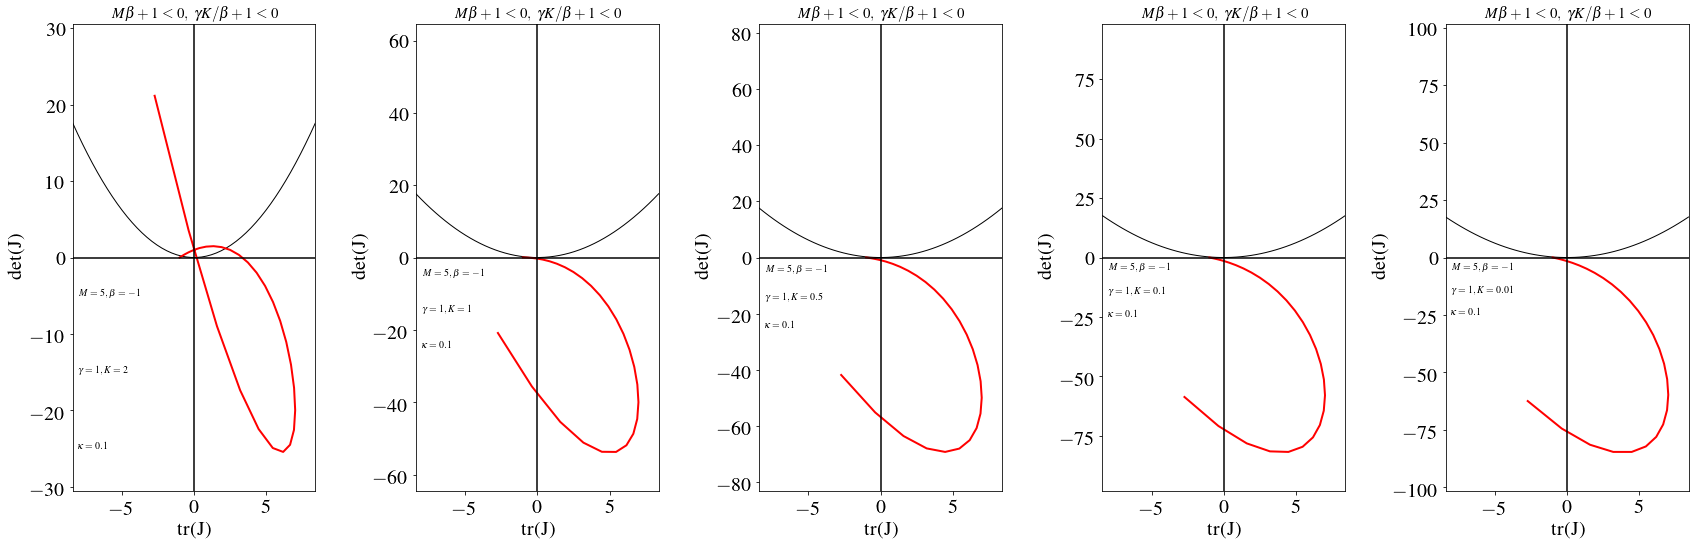

In [5]:
fig, axs = plt.subplots(1, 5, figsize=(24,8), constrained_layout = True)

# Case 1: M*beta + 1 < 0, and gamma*K/beta + 1 < 0

params = {'M': 5,
          'beta': -1,
          'gamma': 1,
          'K': 2,
          'kappa': 0.1
         }

q_range = np.linspace(0,2.9,30)
analysis_obj = approximation_2(params)
analysis_obj.plot_phase_plot(axs[0], q_range)
axs[0].set_title(r'$M \beta + 1 < 0, ~ \gamma K / \beta + 1 < 0$', fontsize=15)
axs[0].text(-8.0, -5.0, r'$M = 5, \beta = -1$', fontsize=10)
axs[0].text(-8.0, -15.0, r'$\gamma = 1, K = 2$', fontsize=10)
axs[0].text(-8.0, -25.0, r'$\kappa = 0.1$', fontsize=10)


params = {'M': 5,
          'beta': -1,
          'gamma': 1,
          'K': 1,
          'kappa': 0.1
         }

q_range = np.linspace(0,2.9,30)
analysis_obj = approximation_2(params)
analysis_obj.plot_phase_plot(axs[1], q_range)
axs[1].set_title(r'$M \beta + 1 < 0, ~ \gamma K / \beta + 1 < 0$', fontsize=15)
axs[1].text(-8.0, -5.0, r'$M = 5, \beta = -1$', fontsize=10)
axs[1].text(-8.0, -15.0, r'$\gamma = 1, K = 1$', fontsize=10)
axs[1].text(-8.0, -25.0, r'$\kappa = 0.1$', fontsize=10)

params = {'M': 5,
          'beta': -1,
          'gamma': 1,
          'K': 0.5,
          'kappa': 0.1
         }

q_range = np.linspace(0,2.9,30)
analysis_obj = approximation_2(params)
analysis_obj.plot_phase_plot(axs[2], q_range)
axs[2].set_title(r'$M \beta + 1 < 0, ~ \gamma K / \beta + 1 < 0$', fontsize=15)
axs[2].text(-8.0, -5.0, r'$M = 5, \beta = -1$', fontsize=10)
axs[2].text(-8.0, -15.0, r'$\gamma = 1, K = 0.5$', fontsize=10)
axs[2].text(-8.0, -25.0, r'$\kappa = 0.1$', fontsize=10)



params = {'M': 5,
          'beta': -1,
          'gamma': 1,
          'K': 0.1,
          'kappa': 0.1
         }

q_range = np.linspace(0,2.9,30)
analysis_obj = approximation_2(params)
analysis_obj.plot_phase_plot(axs[3], q_range)
axs[3].set_title(r'$M \beta + 1 < 0, ~ \gamma K / \beta + 1 < 0$', fontsize=15)
axs[3].text(-8.0, -5.0, r'$M = 5, \beta = -1$', fontsize=10)
axs[3].text(-8.0, -15.0, r'$\gamma = 1, K = 0.1$', fontsize=10)
axs[3].text(-8.0, -25.0, r'$\kappa = 0.1$', fontsize=10)



params = {'M': 5,
          'beta': -1,
          'gamma': 1,
          'K': 0.01,
          'kappa': 0.1
         }

q_range = np.linspace(0,2.9,30)
analysis_obj = approximation_2(params)
analysis_obj.plot_phase_plot(axs[4], q_range)
axs[4].set_title(r'$M \beta + 1 < 0, ~ \gamma K / \beta + 1 < 0$', fontsize=15)
axs[4].text(-8.0, -5.0, r'$M = 5, \beta = -1$', fontsize=10)
axs[4].text(-8.0, -15.0, r'$\gamma = 1, K = 0.01$', fontsize=10)
axs[4].text(-8.0, -25.0, r'$\kappa = 0.1$', fontsize=10)

fig.tight_layout()
plt.savefig('20220526_Stability_Plot_Approximation_2_vary_K_only_oscillations.svg', format='svg', dpi=600)
plt.savefig('20220526_Stability_Plot_Approximation_2_vary_K_only_oscillations.png', format='png', dpi=600)

**Conclusion:** We see a transition from an oscillating regime to a stable pattern

## Analysis of parameter space of the model

**Approximation 2:**

When surface tension effects are important and the species m undergoes only pure diffusion ($w=0$), the trace and determinant are given by:
$$
Tr(J) = - M \kappa q^4 - (M \beta + 1) q^2 - 1 \\
Det(J) = M \kappa q^6 + (M \kappa + M \beta) q^4 + M \beta q^2 \Big( \frac{\gamma K}{\beta} + 1 \Big)
$$

Really, there are only 3 dimensionless parameters in this model:
1. $M\beta$: Strength of phase separation of the species $c$
2. $M\gamma K$: Strength of $c-m$ interaction
3. $M\kappa$: Strength of surface tension

Let us first look at the case where we start with no surface tension and progressively increase it to look at what happens

In [5]:
class dimensionless_model:
    """Class that captures the trace and determinant of the model in approximation 2 in terms of the dimensionless parameters"""
    
    def __init__(self, params):
        """
        Parameters of the model are M_beta, M_gamma_k, and M_kappa
        """
        self.M_beta = params['M_beta'] # Nature of C-C interactions. Attraction if negative
        self.M_gamma_k = params['M_gamma_k'] # Nature of C-M interactions combined with production rate. Attractive if negative 
        self.M_kappa = params['M_kappa'] # Ratio of surface tension to reaction-diffusion length scale
    
    def update_M_beta(self, M_beta):
        """
        Function that updates M_beta value
        """
        self.M_beta = M_beta
        
    def update_M_gamma_k(self, M_gamma_k):
        """
        Function that updates M_gamma_k value
        """
        self.M_gamma_k = M_gamma_k
        
    def update_M_kappa(self, M_kappa):
        """
        Function that updates M_kappa value
        """
        self.M_kappa = M_kappa
    
    def _get_trace(self, q):
        """
        Function that returns the trace of the Jacobian matrix of the linearized model
        """
        return -self.M_kappa*q**4 -(self.M_beta + 1.0)*q**2 - 1.0
    
    def _get_det(self, q):
        """
        Function that returns the determinant of the Jacobian matrix of the linearized model
        """
        return self.M_kappa*q**6 + (self.M_kappa + self.M_beta)*q**4 + q**2*(self.M_gamma_k + self.M_beta)
    
    def get_qualitative_behavior(self, q_list):
        """
        Function that returns the qualitative dynamical behavior of the model as predicted by the linear stability analysis
        Returns: 
        0 for stable system
        1 for unstable system with coarsening
        2 for unstable system with patterns/arrested coarsening
        3 for unstable system with oscillations
        """
        
        behavior = 0
        # Start with the default assumption that the system is stable
        # If we find the system is unstable for any particular wavenumber q^2, then we will change the behavior accordingly
        
        flag_for_first_q_with_positive_eigenvalue = 1
        first_q_with_positive_eigenvalue = 0.0
        
        for q in q_list:
            
            trace_J = self._get_trace(q)
            det_J = self._get_det(q)
            
            if trace_J > 0.0 and det_J > 0.25*trace_J**2: 
                # We have limit cycle oscillations
                behavior = 3
                break
            
            elif (trace_J > 0.0 and det_J < 0.25*trace_J**2) or (det_J < 0.0 and trace_J < 0.0):
                # We have coarsening
                behavior = 1
            
            eigenvalues = [0.5*(trace_J + cmath.sqrt(trace_J**2-4*det_J)), 0.5*(trace_J - cmath.sqrt(trace_J**2-4*det_J))]
            max_real_part = np.max(np.real(eigenvalues))
            if max_real_part > 0.0 and flag_for_first_q_with_positive_eigenvalue:
                flag_for_first_q_with_positive_eigenvalue = 0
                first_q_with_positive_eigenvalue = q
        
        if behavior == 1 and first_q_with_positive_eigenvalue > q_list[1]:
            # We have arrested coarsening
            behavior = 2
            
        return behavior, first_q_with_positive_eigenvalue
    
    def calculate_eigenvalue_spectrum(self, q_list):
        """
        Function that calculates the eigenvalues of the jacobian matrix for different values of q in q_list
        """
        
        spectrum = np.zeros(len(q_list))
        
        for i in range(len(q_list)):
            
            trace_J = self._get_trace(q_list[i])
            det_J = self._get_det(q_list[i])
            
            eigenvalues = [0.5*(trace_J + cmath.sqrt(trace_J**2-4*det_J)), 0.5*(trace_J - cmath.sqrt(trace_J**2-4*det_J))]
            spectrum[i] = np.max(np.real(eigenvalues))
            
        return spectrum

In [14]:
params = {'M_beta': 0.0, 'M_gamma_k': 0.0, 'M_kappa': 0.01}
q_range = np.linspace(0, 10, 401)
N_parameter_points = 81
M_beta_range = np.linspace(-10.0, 10.0, N_parameter_points)
M_gamma_k_range = np.linspace(-10.0, 10.0, N_parameter_points)

nondim_model = dimensionless_model(params)

sweep_parameter_values = np.array([M_beta_range, M_gamma_k_range])

X, Y = np.meshgrid(M_beta_range, M_gamma_k_range)
qualitative_behavior = np.zeros(np.shape(X))
list_of_q_low_calculated = []
list_of_q_predicted = []

for i in range(N_parameter_points):
    for j in range(N_parameter_points):
        nondim_model.update_M_beta(X[i,j])
        nondim_model.update_M_gamma_k(Y[i,j])
        qualitative_behavior[i,j], first_q = nondim_model.get_qualitative_behavior(q_range)
        if qualitative_behavior[i, j] == 2:
            list_of_q_low_calculated.append(first_q)
            list_of_q_predicted.append(np.sqrt(Y[i,j]/X[i,j]) - 1.0)

/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in sqrt


Text(0,0.5,'Predicted $q_{trans}$')

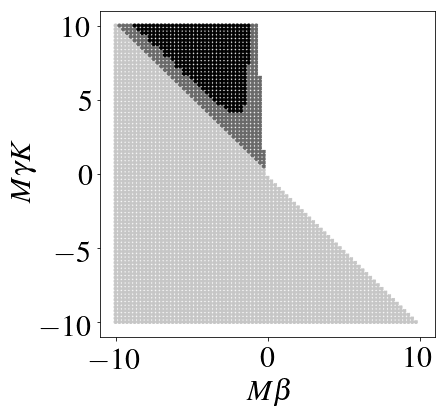

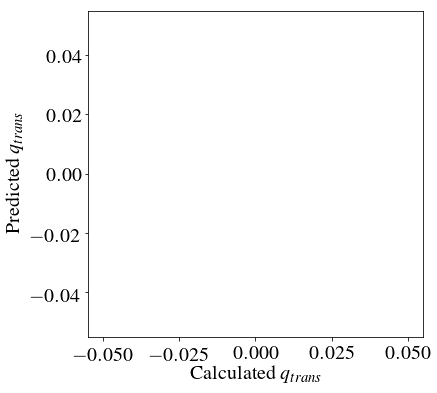

In [15]:
fig, axs = plt.subplots(1,1, figsize=(6,6))
axs.scatter(X.flatten(), Y.flatten(), c=qualitative_behavior.flatten(), s=10, cmap='Greys')
axs.set_xlabel(r'$M\beta$', fontsize=30)
axs.set_ylabel(r'$M\gamma K$', fontsize=30)
axs.tick_params(axis='both', which='major', labelsize=30)

fig, axs = plt.subplots(1,1, figsize=(6,6))
axs.scatter(list_of_q_low_calculated, list_of_q_predicted, s=10)
axs.set_xlabel(r'Calculated $q_{trans}$')
axs.set_ylabel(r'Predicted $q_{trans}$')

In [121]:
print(list_of_q_predicted)

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

Text(0,0.5,'Re($\\lambda$)')

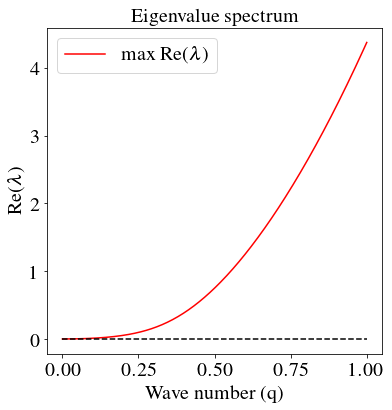

In [100]:
params = {'M_beta': -5.0, 'M_gamma_k': 4.0, 'M_kappa': 0.0}

q_range = np.linspace(0, 5.0, 401)
nondim_model = dimensionless_model(params)
eigenvals = nondim_model.calculate_eigenvalue_spectrum(q_range)
fig, axs = plt.subplots(1, 1, figsize=(6,6))
axs.set_title('Eigenvalue spectrum', fontsize=20)
axs.plot(q_range, eigenvals, '-r', label=r'max Re($\lambda$)')
axs.plot(q_range, np.zeros(len(q_range)), '--k')
axs.legend()
axs.set_xlabel('Wave number (q)')
axs.set_ylabel(r'Re($\lambda$)')

# max_q_index, = np.where(np.real(eigenvals[:, 0]) == np.max(np.real(eigenvals[:, 0])))
# print('Wavelength corresponding to maximum eigenvalue is:' + str(2*np.pi/q_range[max_q_index[0]]))

Text(0,0.5,'Re($\\lambda$)')

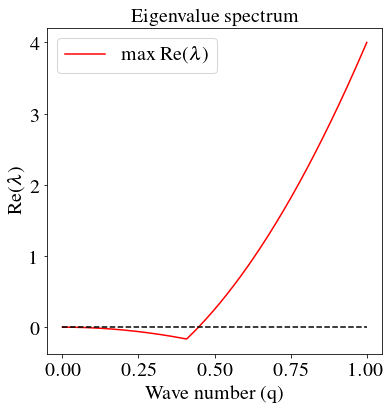

In [105]:
params = {'M_beta': -5.0, 'M_gamma_k': 6.0, 'M_kappa': 0.0}

q_range = np.linspace(0, 1.0, 401)
nondim_model = dimensionless_model(params)
eigenvals = nondim_model.calculate_eigenvalue_spectrum(q_range)
fig, axs = plt.subplots(1, 1, figsize=(6,6))
axs.set_title('Eigenvalue spectrum', fontsize=20)
axs.plot(q_range, eigenvals, '-r', label=r'max Re($\lambda$)')
axs.plot(q_range, np.zeros(len(q_range)), '--k')
axs.legend()
axs.set_xlabel('Wave number (q)')
axs.set_ylabel(r'Re($\lambda$)')

# max_q_index, = np.where(np.real(eigenvals[:, 0]) == np.max(np.real(eigenvals[:, 0])))
# print('Wavelength corresponding to maximum eigenvalue is:' + str(2*np.pi/q_range[max_q_index[0]]))

Text(0,0.5,'Re($\\lambda$)')

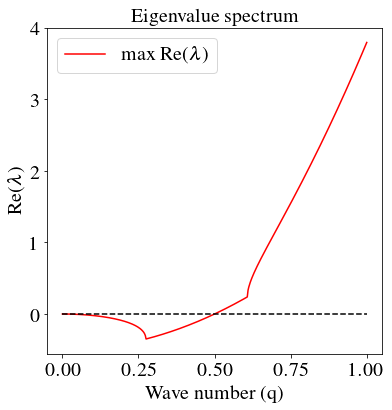

In [109]:
params = {'M_beta': -5.0, 'M_gamma_k': 7.0, 'M_kappa': 0.0}

q_range = np.linspace(0, 1.0, 401)
nondim_model = dimensionless_model(params)
eigenvals = nondim_model.calculate_eigenvalue_spectrum(q_range)
fig, axs = plt.subplots(1, 1, figsize=(6,6))
axs.set_title('Eigenvalue spectrum', fontsize=20)
axs.plot(q_range, eigenvals, '-r', label=r'max Re($\lambda$)')
axs.plot(q_range, np.zeros(len(q_range)), '--k')
axs.legend()
axs.set_xlabel('Wave number (q)')
axs.set_ylabel(r'Re($\lambda$)')

# max_q_index, = np.where(np.real(eigenvals[:, 0]) == np.max(np.real(eigenvals[:, 0])))
# print('Wavelength corresponding to maximum eigenvalue is:' + str(2*np.pi/q_range[max_q_index[0]]))

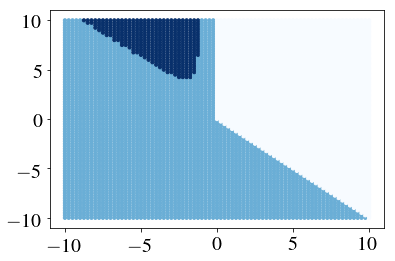

In [135]:
params = {'M_beta': 0.0, 'M_gamma_k': 0.0, 'M_kappa': 0.0}
q_range = np.linspace(0, 60, 4001)
N_parameter_points = 81
M_beta_range = np.linspace(-10.0, 10.0, N_parameter_points)
M_gamma_k_range = np.linspace(-10.0, 10.0, N_parameter_points)

nondim_model = dimensionless_model(params)

sweep_parameter_values = np.array([M_beta_range, M_gamma_k_range])

X, Y = np.meshgrid(M_beta_range, M_gamma_k_range)
qualitative_behavior = np.zeros(np.shape(X))

for i in range(N_parameter_points):
    for j in range(N_parameter_points):
        nondim_model.update_M_beta(X[i,j])
        nondim_model.update_M_gamma_k(Y[i,j])
        qualitative_behavior[i,j] = nondim_model.get_qualitative_behavior(q_range) + 1
        
plt.scatter(X.flatten(), Y.flatten(), c=qualitative_behavior.flatten(), s=10, cmap='Blues')

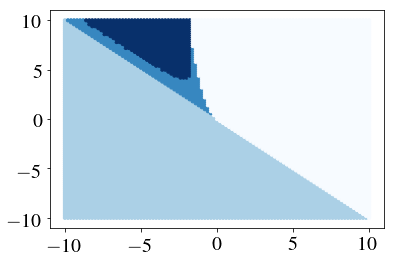

In [107]:
params = {'M_beta': 0.0, 'M_gamma_k': 0.0, 'M_kappa': 0.1}
q_range = np.linspace(0, 10, 401)
N_parameter_points = 101
M_beta_range = np.linspace(-10.0, 10.0, N_parameter_points)
M_gamma_k_range = np.linspace(-10.0, 10.0, N_parameter_points)

nondim_model = dimensionless_model(params)

sweep_parameter_values = np.array([M_beta_range, M_gamma_k_range])

X, Y = np.meshgrid(M_beta_range, M_gamma_k_range)
qualitative_behavior = np.zeros(np.shape(X))

for i in range(N_parameter_points):
    for j in range(N_parameter_points):
        nondim_model.update_M_beta(X[i,j])
        nondim_model.update_M_gamma_k(Y[i,j])
        qualitative_behavior[i,j] = nondim_model.get_qualitative_behavior(q_range) + 1
        
plt.scatter(X.flatten(), Y.flatten(), c=qualitative_behavior.flatten(), s=10, cmap='Blues')

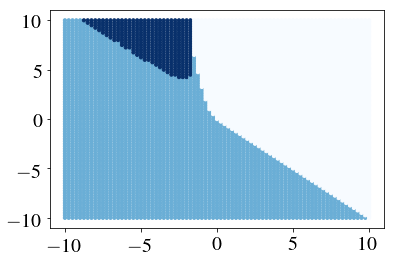

In [134]:
params = {'M_beta': 0.0, 'M_gamma_k': 0.0, 'M_kappa': 0.1}
q_range = np.linspace(0, 60, 4001)
N_parameter_points = 81
M_beta_range = np.linspace(-10.0, 10.0, N_parameter_points)
M_gamma_k_range = np.linspace(-10.0, 10.0, N_parameter_points)

nondim_model = dimensionless_model(params)

sweep_parameter_values = np.array([M_beta_range, M_gamma_k_range])

X, Y = np.meshgrid(M_beta_range, M_gamma_k_range)
qualitative_behavior = np.zeros(np.shape(X))

for i in range(N_parameter_points):
    for j in range(N_parameter_points):
        nondim_model.update_M_beta(X[i,j])
        nondim_model.update_M_gamma_k(Y[i,j])
        qualitative_behavior[i,j] = nondim_model.get_qualitative_behavior(q_range) + 1
        
plt.scatter(X.flatten(), Y.flatten(), c=qualitative_behavior.flatten(), s=10, cmap='Blues')

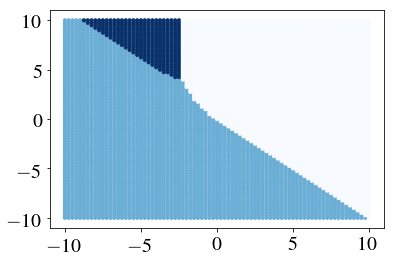

In [136]:
params = {'M_beta': 0.0, 'M_gamma_k': 0.0, 'M_kappa': 0.5}
q_range = np.linspace(0, 60, 4001)
N_parameter_points = 81
M_beta_range = np.linspace(-10.0, 10.0, N_parameter_points)
M_gamma_k_range = np.linspace(-10.0, 10.0, N_parameter_points)

nondim_model = dimensionless_model(params)

sweep_parameter_values = np.array([M_beta_range, M_gamma_k_range])

X, Y = np.meshgrid(M_beta_range, M_gamma_k_range)
qualitative_behavior = np.zeros(np.shape(X))

for i in range(N_parameter_points):
    for j in range(N_parameter_points):
        nondim_model.update_M_beta(X[i,j])
        nondim_model.update_M_gamma_k(Y[i,j])
        qualitative_behavior[i,j] = nondim_model.get_qualitative_behavior(q_range) + 1
        
plt.scatter(X.flatten(), Y.flatten(), c=qualitative_behavior.flatten(), s=10, cmap='Blues')

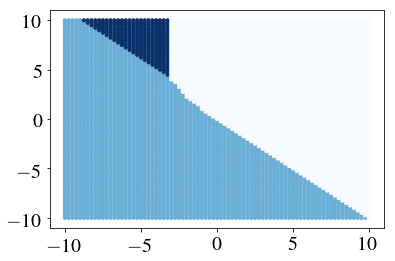

In [137]:
params = {'M_beta': 0.0, 'M_gamma_k': 0.0, 'M_kappa': 1.0}
q_range = np.linspace(0, 60, 4001)
N_parameter_points = 81
M_beta_range = np.linspace(-10.0, 10.0, N_parameter_points)
M_gamma_k_range = np.linspace(-10.0, 10.0, N_parameter_points)

nondim_model = dimensionless_model(params)

sweep_parameter_values = np.array([M_beta_range, M_gamma_k_range])

X, Y = np.meshgrid(M_beta_range, M_gamma_k_range)
qualitative_behavior = np.zeros(np.shape(X))

for i in range(N_parameter_points):
    for j in range(N_parameter_points):
        nondim_model.update_M_beta(X[i,j])
        nondim_model.update_M_gamma_k(Y[i,j])
        qualitative_behavior[i,j] = nondim_model.get_qualitative_behavior(q_range) + 1
        
plt.scatter(X.flatten(), Y.flatten(), c=qualitative_behavior.flatten(), s=10, cmap='Blues')

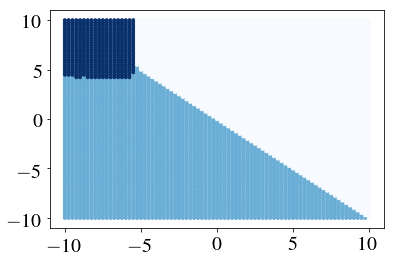

In [138]:
params = {'M_beta': 0.0, 'M_gamma_k': 0.0, 'M_kappa': 5.0}
q_range = np.linspace(0, 60, 4001)
N_parameter_points = 81
M_beta_range = np.linspace(-10.0, 10.0, N_parameter_points)
M_gamma_k_range = np.linspace(-10.0, 10.0, N_parameter_points)

nondim_model = dimensionless_model(params)

sweep_parameter_values = np.array([M_beta_range, M_gamma_k_range])

X, Y = np.meshgrid(M_beta_range, M_gamma_k_range)
qualitative_behavior = np.zeros(np.shape(X))

for i in range(N_parameter_points):
    for j in range(N_parameter_points):
        nondim_model.update_M_beta(X[i,j])
        nondim_model.update_M_gamma_k(Y[i,j])
        qualitative_behavior[i,j] = nondim_model.get_qualitative_behavior(q_range) + 1
        
plt.scatter(X.flatten(), Y.flatten(), c=qualitative_behavior.flatten(), s=10, cmap='Blues')

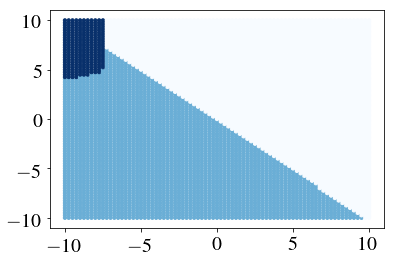

In [139]:
params = {'M_beta': 0.0, 'M_gamma_k': 0.0, 'M_kappa': 10.0}
q_range = np.linspace(0, 60, 4001)
N_parameter_points = 81
M_beta_range = np.linspace(-10.0, 10.0, N_parameter_points)
M_gamma_k_range = np.linspace(-10.0, 10.0, N_parameter_points)

nondim_model = dimensionless_model(params)

sweep_parameter_values = np.array([M_beta_range, M_gamma_k_range])

X, Y = np.meshgrid(M_beta_range, M_gamma_k_range)
qualitative_behavior = np.zeros(np.shape(X))

for i in range(N_parameter_points):
    for j in range(N_parameter_points):
        nondim_model.update_M_beta(X[i,j])
        nondim_model.update_M_gamma_k(Y[i,j])
        qualitative_behavior[i,j] = nondim_model.get_qualitative_behavior(q_range) + 1
        
plt.scatter(X.flatten(), Y.flatten(), c=qualitative_behavior.flatten(), s=10, cmap='Blues')

## Plot eigenvalue spectrum and get wavelength correponding the maximum eigenvalue

### Pattern formation

Wavelength corresponding to maximum eigenvalue is:2.962073073384662


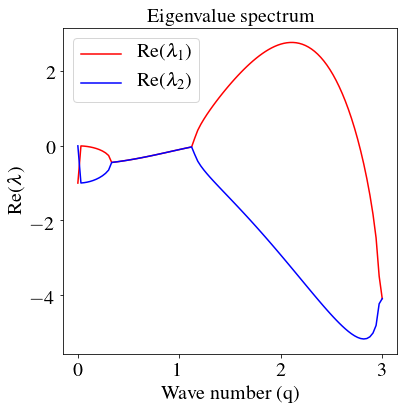

In [30]:
params = {'M': 2,
          'beta': -1,
          'gamma': 1,
          'K': 2,
          'kappa': 0.1
         }

q_range = np.linspace(0,3,100)
analysis_obj = approximation_2(params)
eigenvals = np.array([analysis_obj._get_eigenvalues(q_range[i]) for i in range(np.shape(q_range)[0])])
fig, axs = plt.subplots(1, 1, figsize=(6,6))
axs.set_title('Eigenvalue spectrum', fontsize=20)
axs.plot(q_range, np.real(eigenvals[:, 0]), '-r', label=r'Re($\lambda_1$)')
axs.plot(q_range, np.real(eigenvals[:, 1]), '-b', label=r'Re($\lambda_2$)')
axs.legend()
axs.set_xlabel('Wave number (q)')
axs.set_ylabel(r'Re($\lambda$)')
plt.savefig('eigenvalue_spectrum_pattern_formation.png', format='png')
plt.savefig('eigenvalue_spectrum_pattern_formation.svg', format='svg')

max_q_index, = np.where(np.real(eigenvals[:, 0]) == np.max(np.real(eigenvals[:, 0])))
print('Wavelength corresponding to maximum eigenvalue is:' + str(2*np.pi/q_range[max_q_index[0]]))

### Oscillations

Wavelength corresponding to maximum eigenvalue is:2.962073073384662


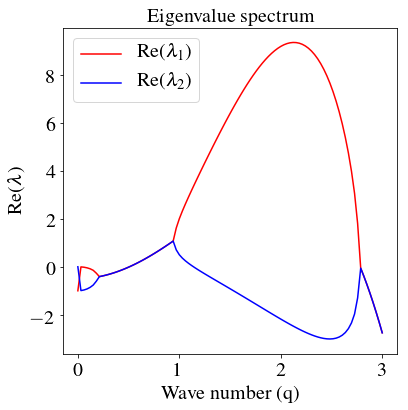

In [31]:
params = {'M': 5,
          'beta': -1,
          'gamma': 1,
          'K': 2,
          'kappa': 0.1
         }

q_range = np.linspace(0,3,100)
analysis_obj = approximation_2(params)
eigenvals = np.array([analysis_obj._get_eigenvalues(q_range[i]) for i in range(np.shape(q_range)[0])])
fig, axs = plt.subplots(1, 1, figsize=(6,6))
axs.set_title('Eigenvalue spectrum', fontsize=20)
axs.plot(q_range, np.real(eigenvals[:, 0]), '-r', label=r'Re($\lambda_1$)')
axs.plot(q_range, np.real(eigenvals[:, 1]), '-b', label=r'Re($\lambda_2$)')
axs.legend()
axs.set_xlabel('Wave number (q)')
axs.set_ylabel(r'Re($\lambda$)')
plt.savefig('eigenvalue_spectrum_oscillations.png', format='png')
plt.savefig('eigenvalue_spectrum_oscillations.svg', format='svg')

max_q_index, = np.where(np.real(eigenvals[:, 0]) == np.max(np.real(eigenvals[:, 0])))
print('Wavelength corresponding to maximum eigenvalue is:' + str(2*np.pi/q_range[max_q_index[0]]))

## Get concentration profiles from simulations

In [7]:
def create_circular_mesh(radius, cell_size):
    """Initialize a circular 2D mesh object depending on the radius and cell size. This uses the function Gmsh2D()

    Args:
        radius (float): Radius of the total domain

        cell_size (float): Side length of a discrete mesh element
        
    Returns:
        mesh (Gmsh2D.mesh): 2D circular mesh
    """
    # Construct a circular mesh
    mesh = Gmsh2D('''   cell_size = %g;
                             radius = %g;
                             Point(1) = {0, 0, 0, cell_size};
                             Point(2) = {-radius, 0, 0, cell_size};
                             Point(3) = {0, radius, 0, cell_size};
                             Point(4) = {radius, 0, 0, cell_size};
                             Point(5) = {0, -radius, 0, cell_size};
                             Circle(6) = {2, 1, 3};
                             Circle(7) = {3, 1, 4};
                             Circle(8) = {4, 1, 5};
                             Circle(9) = {5, 1, 2};
                             Line Loop(10) = {6, 7, 8, 9};
                             Plane Surface(11) = {10};
                          ''' % (cell_size, radius))
    return mesh

### Pattern formation

In [8]:
radius = 50.0
dx = 0.25

mesh = create_circular_mesh(radius, dx)

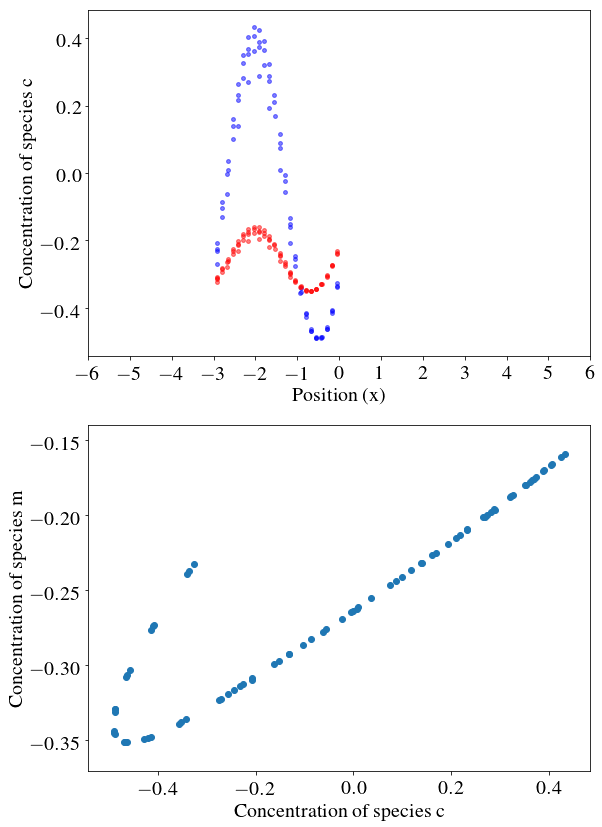

In [14]:
delta = 1.5*dx
indices = [(mesh.y < delta) * (mesh.y > -delta) * (mesh.x < 0.0) * (mesh.x > -3.0)]
# indices = [(mesh.y < delta) * (mesh.y > -delta) * (mesh.x < 0.15*radius) * (mesh.x > -0.15*radius)]

directory = '/nfs/arupclab001/npradeep96/Stability_analysis/TwoComponentModelBRD/Pattern_formation/simulation_steps_1500_domain_size_50_circular/Nucleated_seed_offcenter/M_1_2.0_beta_-1.0_gamma_1.0_kappa_0.1_K_2.0'

df = pd.read_csv(os.path.join(directory, 'Mesh', 'mesh_' + str(i*500) + '.txt'), '\t')

concentration_profile_0 = fp.CellVariable(mesh=mesh, value=f['c_0'][-counter]) 
concentration_profile_1 = fp.CellVariable(mesh=mesh, value=f['c_1'][-counter]) 

fig,axs = plt.subplots(2,1,figsize=(9,14))
axs[0].scatter((mesh.x[indices]).value,
            (concentration_profile_0[indices]).value, 
            label=r"c", s=15, alpha=0.5, c='blue')
axs[0].scatter((mesh.x[indices]).value,
            (concentration_profile_1[indices]).value, 
            label=r"c", s=15, alpha=0.5, c='red')
axs[0].set_xticks(np.linspace(-6,6, 13))
axs[0].set_xlabel('Position (x)')
axs[0].set_ylabel('Concentration of species c')

axs[1].scatter((concentration_profile_0[indices]).value, (concentration_profile_1[indices]).value)
axs[1].set_xlabel('Concentration of species c')
axs[1].set_ylabel('Concentration of species m')

plt.savefig('concentration_1Dplot_pattern.svg', format='svg')
plt.savefig('concentration_1Dplot_pattern.png', format='png')

In [140]:
radius = 10.0
dx = 0.1

mesh = create_circular_mesh(radius, dx)

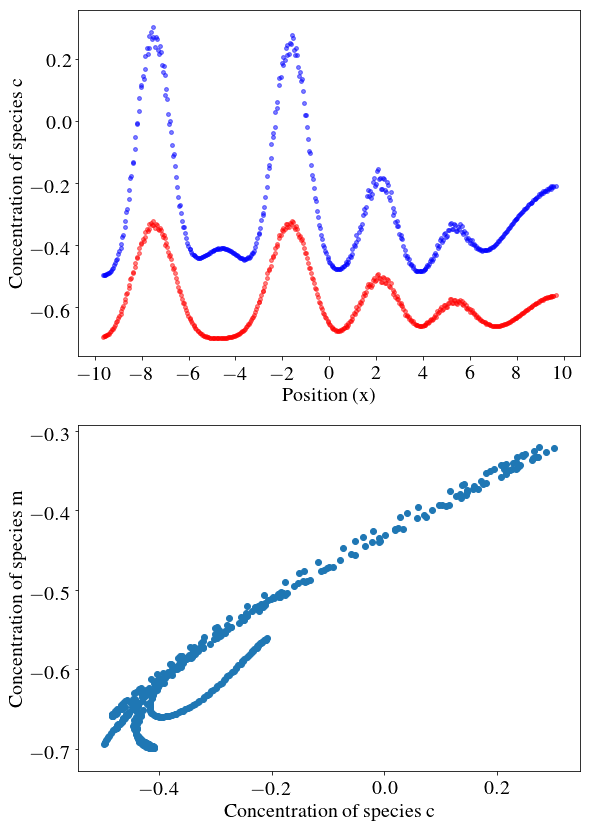

In [150]:
delta = 0.5*dx
indices = [(mesh.y < -2.5 + delta) * (mesh.y > -2.5 - delta) * (mesh.x < radius) * (mesh.x > -radius)]
# indices = [(mesh.y < delta) * (mesh.y > -delta) * (mesh.x < 0.15*radius) * (mesh.x > -0.15*radius)]

directory = '/nfs/arupclab001/npradeep96/Stability_analysis/TwoComponentModelBRD/Scanning_concentrations/Pattern_formation/M_1_2.0_beta_-1.0_gamma_1.0_kappa_0.1_c_initial_-0.3_noise_variance_2.0'

with h5py.File(os.path.join(directory, 'spatial_variables.hdf5'), 'r') as f:
    
    counter = 0
    flag = 1
    while flag:
        counter = counter + 1
        sum = np.sum(f['c_0'][-counter])
        if sum != 0.0:
            flag = 0
    
    concentration_profile_0 = fp.CellVariable(mesh=mesh, value=f['c_0'][-counter]) 
    concentration_profile_1 = fp.CellVariable(mesh=mesh, value=f['c_1'][-counter]) 

    fig,axs = plt.subplots(2,1,figsize=(9,14))
    axs[0].scatter((mesh.x[indices]).value,
                (concentration_profile_0[indices]).value, 
                label=r"c", s=15, alpha=0.5, c='blue')
    axs[0].scatter((mesh.x[indices]).value,
                (concentration_profile_1[indices]).value, 
                label=r"c", s=15, alpha=0.5, c='red')
    axs[0].set_xticks(np.linspace(-10,10, 11))
    axs[0].set_xlabel('Position (x)')
    axs[0].set_ylabel('Concentration of species c')
    
    axs[1].scatter((concentration_profile_0[indices]).value, (concentration_profile_1[indices]).value)
    axs[1].set_xlabel('Concentration of species c')
    axs[1].set_ylabel('Concentration of species m')
    
    # plt.savefig('concentration_1Dplot_pattern.svg', format='svg')
    # plt.savefig('concentration_1Dplot_pattern.png', format='png')

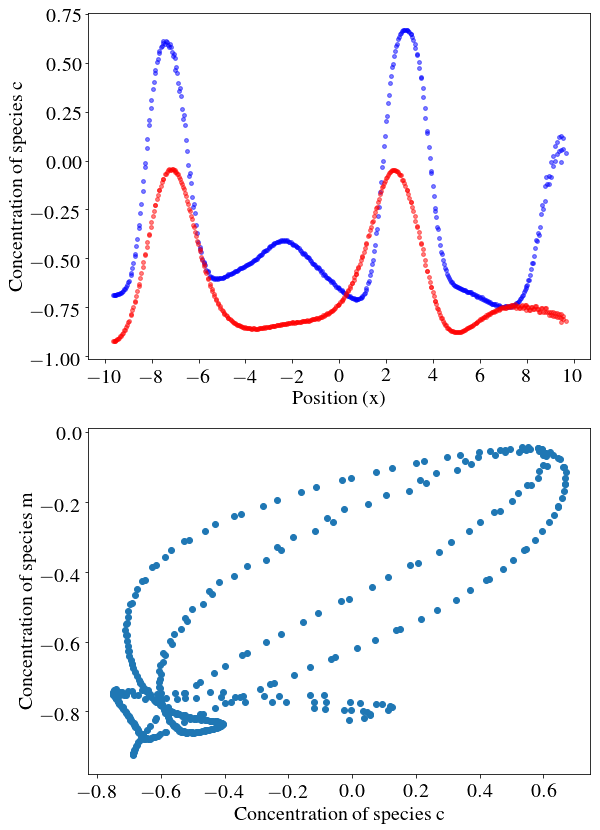

In [151]:
delta = 0.5*dx
indices = [(mesh.y < -2.5 + delta) * (mesh.y > -2.5 - delta) * (mesh.x < radius) * (mesh.x > -radius)]
# indices = [(mesh.y < delta) * (mesh.y > -delta) * (mesh.x < 0.15*radius) * (mesh.x > -0.15*radius)]

directory = '/nfs/arupclab001/npradeep96/Stability_analysis/TwoComponentModelBRD/Scanning_concentrations/Oscillations/M_1_5.0_beta_-1.0_gamma_1.0_kappa_0.1_c_initial_-0.3_noise_variance_2.0'

with h5py.File(os.path.join(directory, 'spatial_variables.hdf5'), 'r') as f:
    
    counter = 0
    flag = 1
    while flag:
        counter = counter + 1
        sum = np.sum(f['c_0'][-counter])
        if sum != 0.0:
            flag = 0
    
    concentration_profile_0 = fp.CellVariable(mesh=mesh, value=f['c_0'][-counter]) 
    concentration_profile_1 = fp.CellVariable(mesh=mesh, value=f['c_1'][-counter]) 

    fig,axs = plt.subplots(2,1,figsize=(9,14))
    axs[0].scatter((mesh.x[indices]).value,
                (concentration_profile_0[indices]).value, 
                label=r"c", s=15, alpha=0.5, c='blue')
    axs[0].scatter((mesh.x[indices]).value,
                (concentration_profile_1[indices]).value, 
                label=r"c", s=15, alpha=0.5, c='red')
    axs[0].set_xticks(np.linspace(-10,10, 11))
    axs[0].set_xlabel('Position (x)')
    axs[0].set_ylabel('Concentration of species c')
    
    axs[1].scatter((concentration_profile_0[indices]).value, (concentration_profile_1[indices]).value)
    axs[1].set_xlabel('Concentration of species c')
    axs[1].set_ylabel('Concentration of species m')
    
    # plt.savefig('concentration_1Dplot_pattern.svg', format='svg')
    # plt.savefig('concentration_1Dplot_pattern.png', format='png')

In [1]:
delta = 0.5*dx
indices = [(mesh.y < -2.5 + delta) * (mesh.y > -2.5 - delta) * (mesh.x < radius) * (mesh.x > -radius)]
# indices = [(mesh.y < delta) * (mesh.y > -delta) * (mesh.x < 0.15*radius) * (mesh.x > -0.15*radius)]

directory = '/nfs/arupclab001/npradeep96/Stability_analysis/TwoComponentModelBRD/Scanning_concentrations/Oscillations/M_1_5.0_beta_-1.0_gamma_1.0_kappa_0.1_c_initial_-0.3_noise_variance_2.0'

with h5py.File(os.path.join(directory, 'spatial_variables.hdf5'), 'r') as f:
    
    counter = 0
    flag = 1
    while flag:
        counter = counter + 1
        sum = np.sum(f['c_0'][-counter])
        if sum != 0.0:
            flag = 0
    
    concentration_profile_0 = fp.CellVariable(mesh=mesh, value=f['c_0'][-counter-2]) 
    concentration_profile_1 = fp.CellVariable(mesh=mesh, value=f['c_1'][-counter-2]) 

    fig,axs = plt.subplots(2,1,figsize=(9,14))
    axs[0].scatter((mesh.x[indices]).value,
                (concentration_profile_0[indices]).value, 
                label=r"c", s=15, alpha=0.5, c='blue')
    axs[0].scatter((mesh.x[indices]).value,
                (concentration_profile_1[indices]).value, 
                label=r"c", s=15, alpha=0.5, c='red')
    axs[0].set_xticks(np.linspace(-10,10, 11))
    axs[0].set_xlabel('Position (x)')
    axs[0].set_ylabel('Concentration of species c')
    
    axs[1].scatter((concentration_profile_0[indices]).value, (concentration_profile_1[indices]).value)
    axs[1].set_xlabel('Concentration of species c')
    axs[1].set_ylabel('Concentration of species m')
    
    # plt.savefig('concentration_1Dplot_pattern.svg', format='svg')
    # plt.savefig('concentration_1Dplot_pattern.png', format='png')

NameError: name 'dx' is not defined

### Oscillations

/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (55) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/times/utmr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))


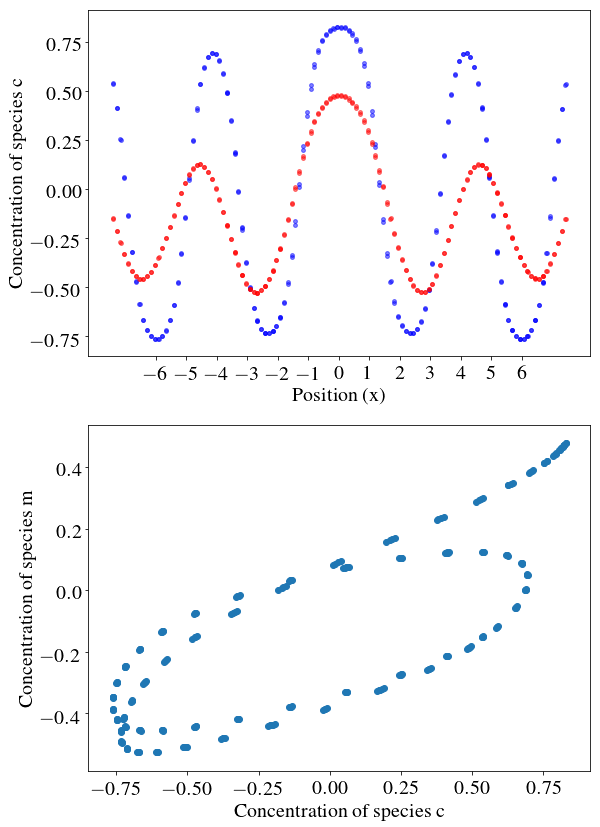

In [15]:
delta = 0.9*dx
indices = [(mesh.y < delta) * (mesh.y > -delta) * (mesh.x < 0.15*radius) * (mesh.x > -0.15*radius)]

directory = '/nfs/arupclab001/npradeep96/Stability_analysis/TwoComponentModelBRD/Oscillations/simulation_steps_1500_domain_size_50_circular/Nucleated_seed_center/M_1_5.0_beta_-1.0_gamma_1.0_kappa_0.1_K_2.0'

with h5py.File(os.path.join(directory, 'spatial_variables.hdf5'), 'r') as f:
    
    counter = 0
    flag = 1
    while flag:
        counter = counter + 1
        sum = np.sum(f['c_0'][-counter])
        if sum != 0.0:
            flag = 0
    
    concentration_profile_0 = fp.CellVariable(mesh=mesh, value=f['c_0'][-counter]) 
    concentration_profile_1 = fp.CellVariable(mesh=mesh, value=f['c_1'][-counter]) 

    fig,axs = plt.subplots(2,1,figsize=(9,14))
    axs[0].scatter((mesh.x[indices]).value,
                (concentration_profile_0[indices]).value, 
                label=r"c", s=15, alpha=0.5, c='blue')
    axs[0].scatter((mesh.x[indices]).value,
                (concentration_profile_1[indices]).value, 
                label=r"c", s=15, alpha=0.5, c='red')
    axs[0].set_xticks(np.linspace(-6,6, 13))
    axs[0].set_xlabel('Position (x)')
    axs[0].set_ylabel('Concentration of species c')
    
    axs[1].scatter((concentration_profile_0[indices]).value, (concentration_profile_1[indices]).value)
    axs[1].set_xlabel('Concentration of species c')
    axs[1].set_ylabel('Concentration of species m')
    
    plt.savefig('concentration_1Dplot_oscillations.svg', format='svg')
    plt.savefig('concentration_1Dplot_oscillations.png', format='png')

## Spatially localized production of species "m"

/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (46) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/times/utmr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))


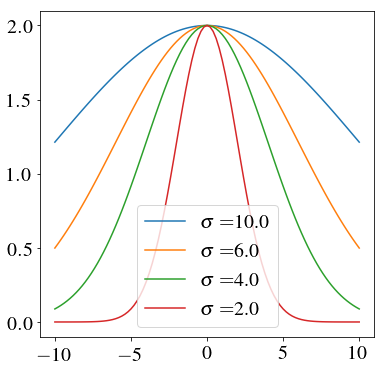

In [42]:
x = np.linspace(-10,10,101)
sigma = [10.0, 6.0, 4.0, 2.0]
fig, axs = plt.subplots(1,1,figsize=(6,6))
for i in range(4):
    axs.plot(x, 2.0*np.exp(-(x*x)/(2*sigma[i]**2)), label=r'$\sigma = $' + str(sigma[i]))
axs.legend()
plt.savefig('Localized_reaction_rates.png', format='png')
plt.savefig('Localized_reaction_rates.svg', format='svg')

## Varying concentrations and transcription rates

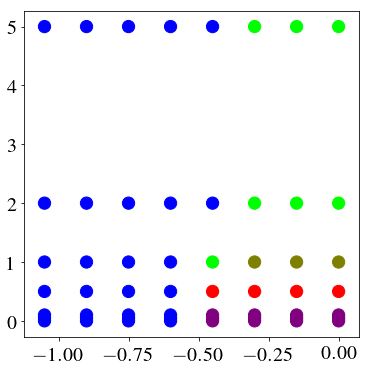

In [8]:
c0_range = np.array([-1.05, -0.9, -0.75, -0.6, -0.45, -0.3, -0.15, 0.0])
K_range = np.array([0.0, 0.05, 0.1, 0.5, 1.0, 2.0 ,5.0])

X, Y = np.meshgrid(c0_range, K_range)
qualitative_behavior = np.array([[0, 0, 0, 0, 1, 1, 1, 1],
                                 [0, 0, 0, 0, 1, 1, 1, 1],
                                 [0, 0, 0, 0, 1, 1, 1, 1],
                                 [0, 0, 0, 0, 2, 2, 2, 2],
                                 [0, 0, 0, 0, 4, 3, 3, 3],
                                 [0, 0, 0, 0, 0, 4, 4, 4],
                                 [0, 0, 0, 0, 0, 4, 4, 4]])*3
        
fig, axs = plt.subplots(1,1,figsize=(6,6))
axs.scatter(X.flatten(), Y.flatten(), c=qualitative_behavior.flatten(), s=150, cmap='brg')
# axs.set_yscale('log')

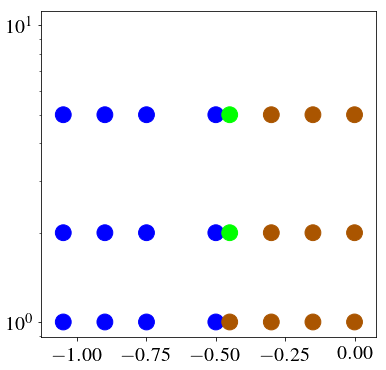

In [15]:
fig, axs = plt.subplots(1,1,figsize=(6,6))
axs.scatter(X.flatten(), Y.flatten(), c=qualitative_behavior.flatten(), s=250, cmap='brg')
axs.set_yscale('log')

In [1]:
## Dynamical behaviors
c0_range = np.array([-1.05, -0.9, -0.75, -0.5, -0.45, -0.3, -0.15, 0.0])
K_range = np.array([0.0, 0.05, 0.1, 0.5, 1.0, 2.0 ,5.0])

X, Y = np.meshgrid(c0_range, K_range)
qualitative_behavior = np.array([[0, 0, 0, 0, 1, 1, 1, 1],
                                 [0, 0, 0, 0, 1, 1, 1, 1],
                                 [0, 0, 0, 0, 1, 1, 1, 1],
                                 [0, 0, 0, 0, 4, 4, 4, 4],
                                 [0, 0, 0, 0, 2, 2, 2, 2],
                                 [0, 0, 0, 0, 3, 2, 2, 2],
                                 [0, 0, 0, 0, 3, 2, 2, 2]])*3
        
fig, axs = plt.subplots(1,1,figsize=(6,6))
axs.scatter(X.flatten(), Y.flatten(), c=qualitative_behavior.flatten(), s=150, cmap='brg')
# axs.set_yscale('log')